In [99]:
from ethograph.utils.video import export_motif_clips


export_motif_clips(
    nc_path=r"C:/Users/Admin/Desktop/trainFreddy/Trial_data2701.nc",
    video_path=r"C:\Users\Admin\Documents\Akseli\VidData\20250527_01_Freddy\2025-05-27_012_Freddy-cam-1.mp4",
    trial_sel=12,
    motif_ids=[1, 2, 3, 4],  # Only motifs 2 and 3
    padding_frames=0,  # Add 10 frames before/after
    slowdown_factor=20, 
)

Exported: motif01_001_trial12_f104-141_x20.0.mp4 (38 frames)
Exported: motif02_001_trial12_f141-184_x20.0.mp4 (44 frames)
Exported: motif03_001_trial12_f242-273_x20.0.mp4 (32 frames)
Exported: motif03_002_trial12_f347-376_x20.0.mp4 (30 frames)
Exported: motif04_001_trial12_f385-414_x20.0.mp4 (30 frames)

Exported 5 clips to C:\Users\Admin\Documents\Akseli\VidData\20250527_01_Freddy\motif_clips


[WindowsPath('C:/Users/Admin/Documents/Akseli/VidData/20250527_01_Freddy/motif_clips/motif01_001_trial12_f104-141_x20.0.mp4'),
 WindowsPath('C:/Users/Admin/Documents/Akseli/VidData/20250527_01_Freddy/motif_clips/motif02_001_trial12_f141-184_x20.0.mp4'),
 WindowsPath('C:/Users/Admin/Documents/Akseli/VidData/20250527_01_Freddy/motif_clips/motif03_001_trial12_f242-273_x20.0.mp4'),
 WindowsPath('C:/Users/Admin/Documents/Akseli/VidData/20250527_01_Freddy/motif_clips/motif03_002_trial12_f347-376_x20.0.mp4'),
 WindowsPath('C:/Users/Admin/Documents/Akseli/VidData/20250527_01_Freddy/motif_clips/motif04_001_trial12_f385-414_x20.0.mp4')]

# deriving speed curves

In [ ]:
%load_ext autoreload
%autoreload 2

from ethograph.utils.io import TrialTree

from ethograph.utils.paths import get_project_root
from ethograph.plots.plot_plt import plot_ds_variable
import matplotlib.pyplot as plt


path = r"C:\Users\Admin\Documents\Akseli\Trial_data_Freddy_20250526_02.nc"
dt = TrialTree.load(path)


ds = dt.trial(141)

ds




style_sheet = get_project_root() / "configs" / "style ppt.mplstyle"
plt.style.use(style_sheet)

fig, ax = plt.subplots(figsize=(8, 4))

plot_ds_variable(
    ax,
    ds.isel(time=slice(230, 300)),
    {'keypoints': 'beakTip', 'individuals': 'Freddy'},
    'speed',
    'angle_rgb'
)
plt.ylabel('beakTip Speed (cm/s)')
plt.xlabel('Time (s)')
plt.title('')
plt.legend().remove()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

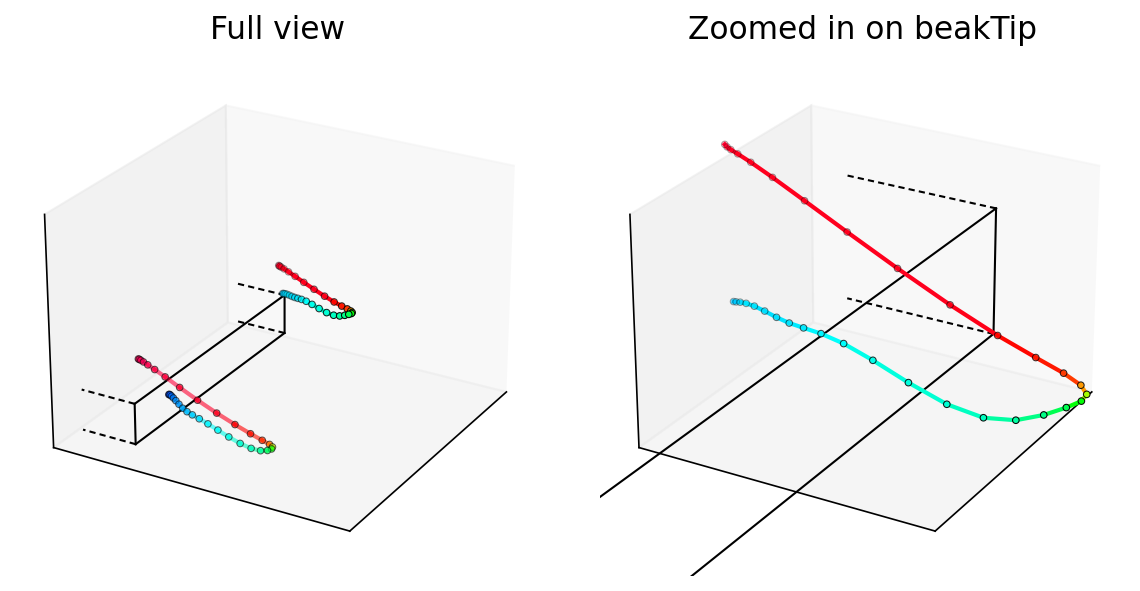

In [82]:
import numpy as np

time_slice = slice(248, 282)

pos_beak = ds.position.sel(keypoints='beakTip', individuals='Freddy').isel(time=time_slice)
X_beak = pos_beak.sel(space='x').values
Y_beak = pos_beak.sel(space='y').values
Z_beak = pos_beak.sel(space='z').values

pos_stick = ds.position.sel(keypoints='stickTip', individuals='Freddy').isel(time=time_slice)
X_stick = pos_stick.sel(space='x').values
Y_stick = pos_stick.sel(space='y').values
Z_stick = pos_stick.sel(space='z').values

color_data_beak = ds.angle_rgb.sel(keypoints='beakTip', individuals='Freddy').isel(time=time_slice).values
color_data_stick = ds.angle_rgb.sel(keypoints='stickTip', individuals='Freddy').isel(time=time_slice).values

if color_data_beak.max() > 1.0:
    color_data_beak = color_data_beak / 255.0
if color_data_stick.max() > 1.0:
    color_data_stick = color_data_stick / 255.0

box_xy_base = np.array([
    [-7.00,  0.00],
    [-7.00,  9.80],
    [ 6.80,  9.80],
    [ 6.80,  0.00]
])
z_bot, z_top = 0.65, 2.75

x_min, x_max = box_xy_base[:, 0].min(), box_xy_base[:, 0].max()
y_min, y_max = box_xy_base[:, 1].min(), box_xy_base[:, 1].max()

vertices = np.array([
    [x_min, y_min, z_bot],
    [x_max, y_min, z_bot],
    [x_max, y_max, z_bot],
    [x_min, y_max, z_bot],
    [x_min, y_min, z_top],
    [x_max, y_min, z_top],
    [x_max, y_max, z_top],
    [x_min, y_max, z_top]
])

front_edges = [(0,1), (4,5), (0,4), (1,5)]
depth_edges = [(0,3), (1,2), (4,7), (5,6)]
depth_fraction = 1/5

# Compute centroid and zoom radius
centroid_x = np.nanmean(X_beak)
centroid_y = np.nanmean(Y_beak)
centroid_z = np.nanmean(Z_beak)
zoom_radius = 1  # Adjust this to control zoom level

fig = plt.figure(figsize=(8, 4))

def draw_scene(ax):
    for v1, v2 in front_edges:
        p1, p2 = vertices[v1], vertices[v2]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'k-', linewidth=1)
    
    for v1, v2 in depth_edges:
        p1, p2 = vertices[v1], vertices[v2]
        p_end = p1 + depth_fraction * (p2 - p1)
        ax.plot([p1[0], p_end[0]], [p1[1], p_end[1]], [p1[2], p_end[2]],
                'k--', linewidth=1, dashes=(3, 2))
    
    for i in range(len(X_beak) - 1):
        ax.plot(X_beak[i:i+2], Y_beak[i:i+2], Z_beak[i:i+2], color=color_data_beak[i], linewidth=2)
    ax.scatter(X_beak, Y_beak, Z_beak, c=color_data_beak, s=10, edgecolors='k', linewidths=0.5, zorder=5)
    
    for i in range(len(X_stick) - 1):
        ax.plot(X_stick[i:i+2], Y_stick[i:i+2], Z_stick[i:i+2], color=color_data_stick[i], linewidth=2, alpha=0.6)
    ax.scatter(X_stick, Y_stick, Z_stick, c=color_data_stick, s=10, edgecolors='k', linewidths=0.5, zorder=5, alpha=0.6)

# Left: full view
ax1 = fig.add_subplot(121, projection='3d')
draw_scene(ax1)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_title('Full view')
ax1.view_init(elev=25, azim=210)

# Right: zoomed view
ax2 = fig.add_subplot(122, projection='3d')
draw_scene(ax2)
ax2.set_xlim(centroid_x - zoom_radius, centroid_x + zoom_radius)
ax2.set_ylim(centroid_y - zoom_radius, centroid_y + zoom_radius)
ax2.set_zlim(centroid_z - zoom_radius, centroid_z + zoom_radius)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_zlabel('')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_title('Zoomed in on beakTip')
ax2.view_init(elev=25, azim=210)

plt.tight_layout()
plt.show()

# syllable length variability

In [89]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
from ethograph.utils.io import TrialTree
import xarray as xr
from typing import Dict, List
from ethograph.utils.data_utils import ds_to_df, stack_trials
import matplotlib.pyplot as plt



paths = [r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250526_01\behav\Trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\Trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_02\behav\Trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\Trial_data.nc"]
        

# 2019528keypoints
# 544952keypoints

# Usage
trees = {f"tree_{i}": TrialTree.load(p) for i, p in enumerate(paths)}
ds = stack_trials(trees, ["labels"], ["poscat", "num_pellets", "human_verified"])
df = ds_to_df(ds)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2026-01-15 18:50:30.666 | WARNING  | pandas.core.groupby.groupby:apply:1832 - C:\Users\Admin\AppData\Local\Temp\ipykernel_11652\1086035441.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_outliers = df[df.groupby('label', group_keys=False).apply(mark_outliers)]

2026-01-15 18:50:30.680 | WARNING  | pandas.core.frame:_getitem_bool_array:4148 - C:\Users\Admin\AppData\Local\Temp\ipykernel_11652\1086035441.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_outliers = df[df.groupby('label', group_keys=False).apply(mark_outliers)]

Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style.mplstyle'), line 10 ('font.size: 13')
Du

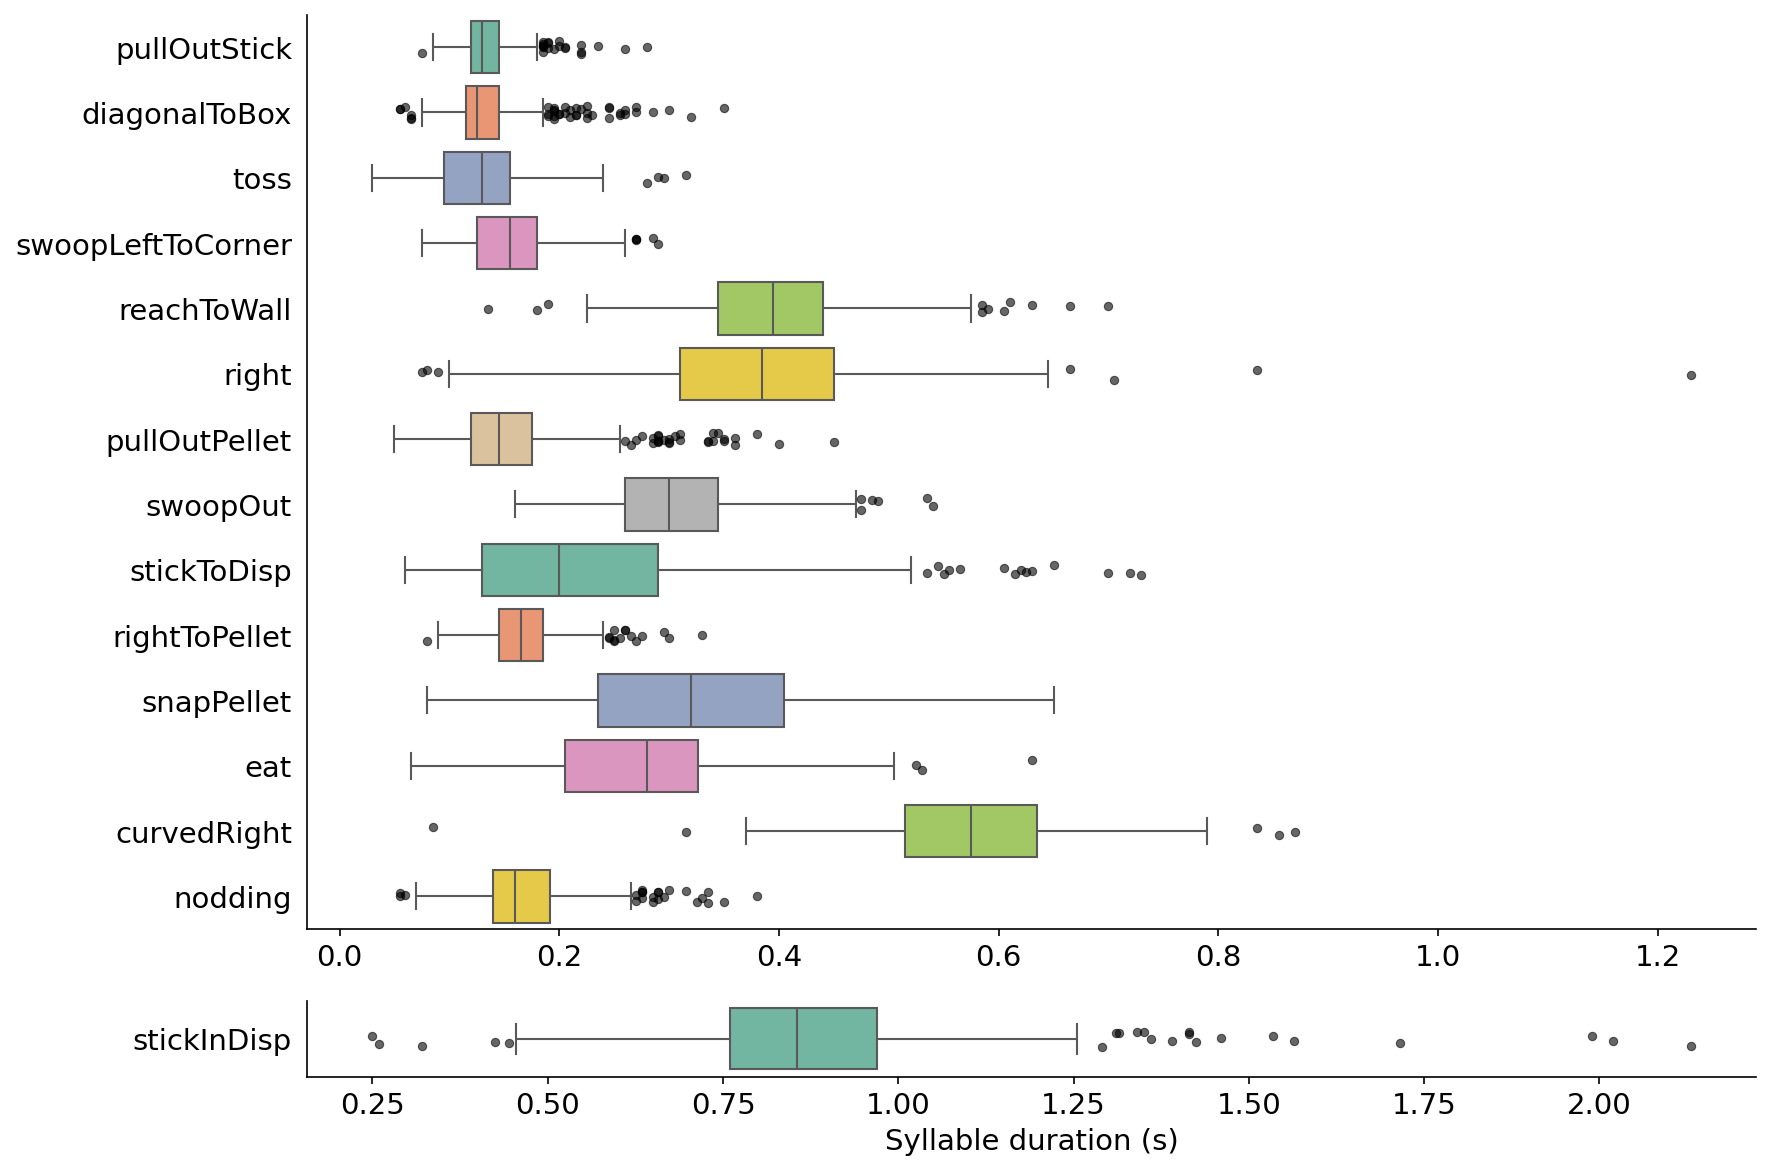

In [93]:

def mark_outliers(group):
    q1 = group['duration'].quantile(0.25)
    q3 = group['duration'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (group['duration'] < lower) | (group['duration'] > upper)

df_outliers = df[df.groupby('label', group_keys=False).apply(mark_outliers)]

from ethograph.utils.paths import get_project_root
from ethograph.utils.labels import load_motif_mapping

mapping_path =  get_project_root() / "configs" / "mapping.txt"
mappings = load_motif_mapping(mapping_path)


from ethograph.utils.paths import get_project_root
style_sheet = get_project_root() / "configs" / "style.mplstyle"
plt.style.use(style_sheet)



label_long = 10

df_main = df[df['label'] != label_long]
df_out_main = df_outliers[df_outliers['label'] != label_long]

df_long = df[df['label'] == label_long]
df_out_long = df_outliers[df_outliers['label'] == label_long]

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    gridspec_kw={'height_ratios': [12, 1]},  # bottom smaller
    sharex=False
)

# ── TOP: all normal labels ─────────────────────────────
sns.boxplot(
    data=df_main,
    x='duration',
    y='label',
    orient='h',
    ax=ax1,
    palette='Set2',
    showfliers=False
)

sns.stripplot(
    data=df_out_main,
    x='duration',
    y='label',
    orient='h',
    ax=ax1,
    color='black',
    size=4,
    alpha=0.6,
    linewidth=0.5
)



# ── BOTTOM: label 10 only ───────────────────────────────
sns.boxplot(
    data=df_long,
    x='duration',
    y='label',
    orient='h',
    ax=ax2,
    palette='Set2',
    showfliers=False
)

sns.stripplot(
    data=df_out_long,
    x='duration',
    y='label',
    orient='h',
    ax=ax2,
    color='black',
    size=4,
    alpha=0.6,
    linewidth=0.5
)


ax1.set_ylabel('')
ax2.set_ylabel('')

# ── Replace numeric labels with motif names ─────────────
label_to_name = {k: v['name'] for k, v in mappings.items()}

# Top subplot labels
ylabels = [int(t.get_text()) for t in ax1.get_yticklabels()]
ax1.set_yticklabels([label_to_name[l] for l in ylabels])

# Bottom subplot label
ax2.set_yticklabels([label_to_name[label_long]])

ax1.set_xlabel('')
ax2.set_xlabel('Syllable duration (s)'
               
               )

# ── Remove plot boxes (spines) ─────────────────────────
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

remove_spines(ax1)
remove_spines(ax2)

ax1.tick_params(left=False)
ax2.tick_params(left=False)

plt.tight_layout()
plt.show()

In [ ]:
ds